# Underfitting and overfitting

Import the required modules.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit

## Target function

Define the target function as a quadratic function in one variable.

In [2]:
def target_function(x):
    return -(x + 1.0)*(x - 5.0)

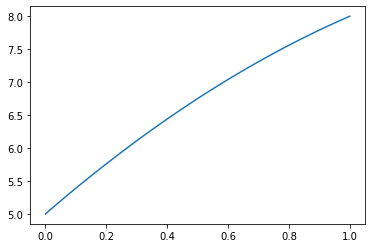

In [3]:
x = np.linspace(0.0, 1.0, 101)
y = target_function(x)
_ = plt.plot(x, y)

In the interval $[0, 1]$, the function is almost linear.

## Generate data

To obtain repeatable results, we seed the random number genrator.

In [4]:
np.random.seed(1234)

The data consists of arbitrary points in the interval $[0, 1]$ for $x$-values, and the corresponding function values with noise added.  The noise is drawn from a normal distribution with mean value 0.0 and standard deviation 0.2.

In [5]:
def generate_noisy_data(func, x_min=0.0, x_max=1.0, noise=0.2, nr_points=20):
    x = np.random.uniform(x_min, x_max, (nr_points,))
    y = func(x) + np.random.normal(0.0, noise, x.shape)
    return x, y

To display the data, we define a function.

In [6]:
def show_data(func, x_data, y_data, x_min=0.0, x_max=1.0):
    _ = plt.plot(x_data, y_data, 'ro')
    x = np.linspace(x_min, x_max, 101)
    _ = plt.plot(x, func(x))

For computing the fit, we generate 20 data points.

In [7]:
x_train, y_train = generate_noisy_data(target_function, noise=0.2, nr_points=20)

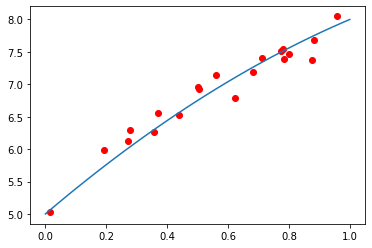

In [8]:
show_data(target_function, x_train, y_train)

To validate the fit, we generate 20 additional data points.

In [9]:
x_val, y_val = generate_noisy_data(target_function, noise=0.2, nr_points=20)

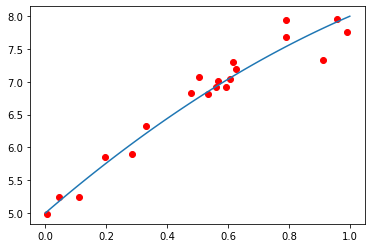

In [10]:
show_data(target_function, x_val, y_val)

We also generate some points outside the interval $[0.0, 1.0]$, i.e., in $[1.0, 1.5]$.

In [11]:
x_extra, y_extra = generate_noisy_data(target_function, x_min=1.0, x_max=1.5, noise=0.2, nr_points=20)

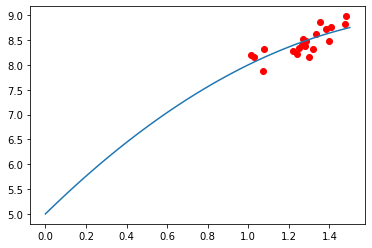

In [12]:
show_data(target_function, x_extra, y_extra, x_min=0.0, x_max=1.5)

## Fitting

The functions to fit a polynomials with a given degree.  The degree is determined by the number of parameters given to the function, i.e.,
$$
    f(x) = \sum_{i=0}^{d} p_i x^i
$$
Here, $d$ is the degree of the polinomial, and $\vec{p}$ represents the coefficients of that polynomial.

In [9]:
def fit_func(x, *params):
    x_facts = [x**i for i in range(len(params))]
    return sum(param*x_fact for param, x_fact in zip(params, x_facts))

The optimal values $\vec{p}_{\rm opt}$ for $\vec{p}$ are computed using the `curve_fit` function in scipy's `optimize` module.  The covariances are ignored.

In [10]:
def compute_params(fit_func, xs, ys, degree):
    p0 = [1.0]*(degree + 1)
    p_opt, _ = curve_fit(fit_func, xs, ys, p0)
    return p_opt

We can now compute the optimal values of the coefficients for polynomials of degree 1 to 6.

In [11]:
p_opts = [compute_params(fit_func, x_train, y_train, degree) for degree in range(1,20,5)]

To visualize the results, we define a function that plots the polynomial defined by $\vec{p}_{\rm opt}$, as well as the points used for fitting.

In [18]:
def show_fit(fit_func, xs, ys, p_opt, x_min=0.0, x_max=1.0):
    x = np.linspace(x_min, x_max, 101)
    _ = plt.plot(x, fit_func(x, *p_opt))
    _ = plt.plot(xs, ys, 'ro')
    plt.title( f'degree = {len(p_opt) - 1}')
    plt.show()

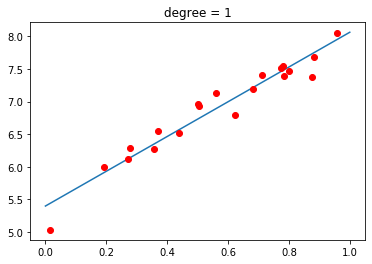

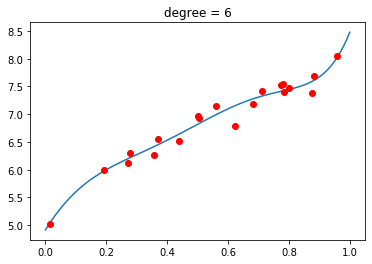

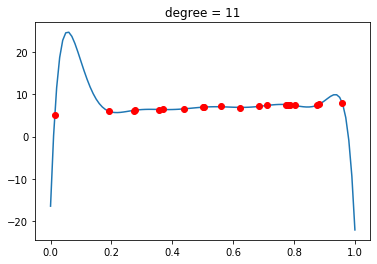

In [19]:
for p_opt in p_opts:
    show_fit(fit_func, x_train, y_train, p_opt)

The fits for polynomials of degree 4, 5 and 6 seem very good.

## Overfitting

Although visually, the polynomials fo degree 5 and 6 seem to describe the data quite well, we should verify by computing the mean square error for the validation data, i.e., the data that has not been used for performing the fit.

In [27]:
def compute_errors(func, xs, ys, params):
    return sum((y - func(x, *params))**2 for x, y in zip(xs, ys))/len(xs)

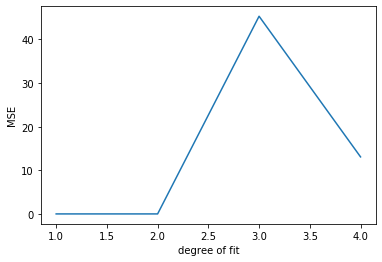

In [28]:
degrees = list(range(1, len(p_opts) + 1))
errors = [compute_errors(fit_func, x_val, y_val, p_opt) for p_opt in p_opts]
_ = plt.plot(degrees, errors)
_ = plt.xlabel('degree of fit')
_ = plt.ylabel('MSE')

In [23]:
degrees

[1, 2, 3, 4]

From the plot, it is clear the mean square error on the validation data is minimal for polynomial of degree 2.  The polynomials of degree 3 to 6 clearly overfitted the data, i.e., are too specifically tuned towards the training data.

## Underfitting

The mean square error for the linear fit is quite large as well, but this is obviously not due to overfitting.  The model is simply not powerful enough to describe the data, which results in a large MSE.

## The wrong question

How well do the fits generalize to data that was not part of the training set?  As it turns out, not all too well.  Below you see plots for data that is in the interval $[1.0, 1.5]$.

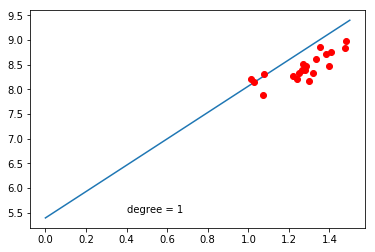

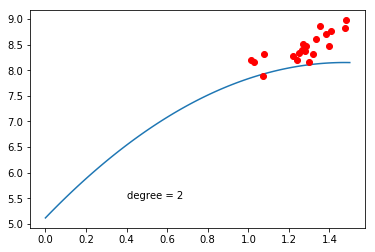

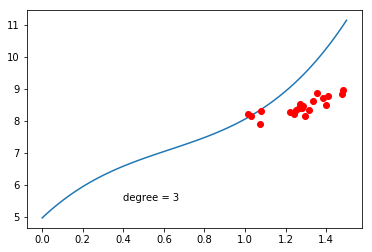

In [176]:
for p_opt in p_opts[:3]:
    show_fit(fit_func, x_extra, y_extra, p_opt, x_min=0.0, x_max=1.5)

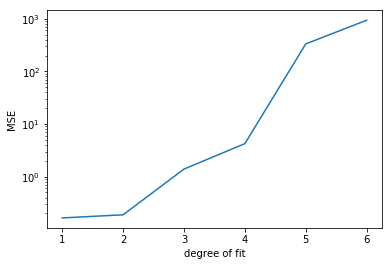

In [191]:
degrees = list(range(1, len(p_opts) + 1))
errors = [compute_errors(fit_func, x_extra, y_extra, p_opt) for p_opt in p_opts]
_ = plt.semilogy(degrees, errors)
_ = plt.xlabel('degree of fit')
_ = plt.ylabel('MSE')

For this particular training data, it turns out that the polynomial of degree 2 is not a good fit outside of the interval $[0, 1]$.  The plot below shows the target function and the fitted polynomials of degrees 1 and 2.

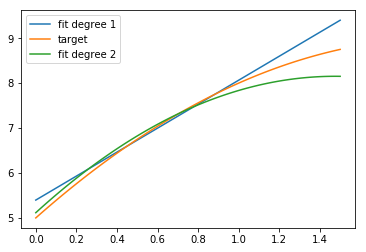

In [193]:
x = np.linspace(0.0, 1.5, 101)
_ = plt.plot(x, fit_func(x, *(p_opts[0])), label='fit degree 1')
_ = plt.plot(x, target_function(x), label='target')
_ = plt.plot(x, fit_func(x, *(p_opts[1])), label='fit degree 2')
_ = plt.legend()